In [23]:
# ===============================
# Librairies
# ===============================
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.io as pio
from IPython.display import Image, display

import yfinance as yf
import ta

from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBClassifier
import optuna
from functools import partial

from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score, matthews_corrcoef, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import shap

In [2]:
# ===============================
# Download daily OHLCV data
# ===============================
#symbol = "^GSPC"
symbol = "ES=F"
start  = "2010-01-01"
end    = None

df = yf.download(symbol, start=start, end=end)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,1128.75,1129.75,1113.25,1113.75,1291254
2010-01-05,1132.25,1133.00,1125.00,1128.50,1378593
2010-01-06,1133.00,1135.50,1127.25,1132.00,1259921
2010-01-07,1137.50,1138.75,1127.00,1133.00,1567025
2010-01-08,1141.50,1141.75,1131.00,1137.25,1527666


In [3]:
# ===============================
# Preprocess the data to add additional informations
# ===============================
def _merge(df_main, ta_obj):  # Add TA output to df_main, regardless of Series/DataFrame type
    if isinstance(ta_obj, pd.DataFrame):
        return pd.concat([df_main, ta_obj], axis=1)
    else:
        return pd.concat([df_main, ta_obj.rename(ta_obj.name if hasattr(ta_obj, "name") else "TA")], axis=1)

def add_indicators(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # ── Momentum ──────────────────────────────────────────────
    for length in [5, 10, 15]:
        df[f"rsi_{length}"] = ta.momentum.RSIIndicator(close=df["Close"], window=length).rsi()
    df["roc_10"] = ta.momentum.ROCIndicator(close=df["Close"], window=10).roc()
    df["mom_10"] = df["Close"] - df["Close"].shift(10)

    # ── Oscillators ───────────────────────────────────────────
    stoch = ta.momentum.StochasticOscillator(high=df["High"], low=df["Low"], close=df["Close"], window=14, smooth_window=3)
    df["stoch_k"] = stoch.stoch()
    df["stoch_d"] = stoch.stoch_signal()
    df["cci_20"] = ta.trend.CCIIndicator(high=df["High"], low=df["Low"], close=df["Close"], window=20).cci()

    kst = ta.trend.KSTIndicator(close=df["Close"])
    df = _merge(df, kst.kst())

    macd = ta.trend.MACD(close=df["Close"])
    df["macd"] = macd.macd()

    # ── Trend ────────────────────────────────────────────────
    for length in [5, 10, 20]:
        df[f"sma_{length}"] = ta.trend.SMAIndicator(close=df["Close"], window=length).sma_indicator()
        df[f"ema_{length}"] = ta.trend.EMAIndicator(close=df["Close"], window=length).ema_indicator()
    df["vwma_20"] = ta.volume.VolumeWeightedAveragePrice(high=df["High"], low=df["Low"], close=df["Close"], volume=df["Volume"], window=20).volume_weighted_average_price()

    # ── Volatility ───────────────────────────────────────────
    bb = ta.volatility.BollingerBands(close=df["Close"], window=20, window_dev=2)
    df = _merge(df, bb.bollinger_mavg())
    df["bb_hband"] = bb.bollinger_hband()
    df["bb_lband"] = bb.bollinger_lband()

    df["atr_14"] = ta.volatility.AverageTrueRange(high=df["High"], low=df["Low"], close=df["Close"], window=14).average_true_range()

    kc = ta.volatility.KeltnerChannel(high=df["High"], low=df["Low"], close=df["Close"], window=20)
    df["kc_hband"] = kc.keltner_channel_hband()
    df["kc_lband"] = kc.keltner_channel_lband()

    # ── Volume ───────────────────────────────────────────────
    df["obv"] = ta.volume.OnBalanceVolumeIndicator(close=df["Close"], volume=df["Volume"]).on_balance_volume()
    df["ad"] = ta.volume.AccDistIndexIndicator(high=df["High"], low=df["Low"], close=df["Close"], volume=df["Volume"]).acc_dist_index()

    return df

# Example usage
df_ta = add_indicators(df)
df_ta.tail()


,Close,High,Low,Open,Volume,rsi_5,rsi_10,rsi_15,roc_10,mom_10,stoch_k,stoch_d,cci_20,kst,macd,sma_5,ema_5,sma_10,ema_10,sma_20,ema_20,vwma_20,mavg,bb_hband,bb_lband,atr_14,kc_hband,kc_lband,obv,ad
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2026-01-15,6981.75,7017.25,6949.50,6955.75,1293668,53.806170,57.520726,57.626032,1.294886,89.25,67.846608,68.731563,62.676336,22.692274,41.244989,6994.25,6982.775465,6972.850,6971.655638,6933.727002,6941.133736,6939.751955,6933.727002,7088.078954,6779.375050,66.594152,6989.675667,6874.950667,192741823,6.108249e+08
2026-01-16,6976.75,7007.00,6960.50,6986.75,1297479,51.129446,56.394558,56.959115,1.104992,76.25,64.896755,63.815143,59.231213,23.465192,39.075031,6988.60,6980.766977,6980.475,6972.581885,6946.239502,6944.525762,6947.008604,6946.239502,7068.631757,6823.847247,65.158856,6997.971501,6888.896501,191444344,6.104343e+08
2026-01-20,6829.50,6935.00,6822.25,6918.25,2391547,18.058449,34.373282,41.722926,-1.645365,-114.25,3.387850,45.377071,-155.854276,21.866032,25.183184,6951.20,6930.344651,6969.050,6946.566997,6948.802002,6933.570927,6941.623379,6948.802002,7058.506724,6839.097280,71.540366,7003.192334,6892.667334,189052797,6.083503e+08
2026-01-21,6910.00,6945.25,6814.50,6839.00,2391547,43.175250,46.955184,49.616996,-1.112661,-77.75,43.066516,37.117041,-137.778142,20.261426,20.433922,6932.85,6923.563101,6961.275,6939.918452,6954.475000,6931.326077,6945.219602,6954.475000,7041.485186,6867.464814,75.769626,7013.033333,6892.908333,191444344,6.094523e+08
2026-01-22,6959.25,6964.50,6911.25,6920.00,759973,53.966153,53.071254,53.725803,-0.057444,-4.00,65.276212,37.243526,-20.821422,19.151780,20.408901,6931.45,6935.458734,6960.875,6943.433279,6955.925000,6933.985498,6946.122426,6955.925000,7042.235790,6869.614210,74.250367,7015.041667,6893.166667,192204317,6.100624e+08


In [4]:
# ===============================
# Label generation: future‑aware classification targets
# ===============================
def generate_label(
        data: pd.DataFrame,
        lookahead: int = 5,
        thresh: float = 0.01,
        col: str = "Close"
) -> pd.Series:
    """
    Label each row from the mean of the next lookahead closes:
      2 : future_mean ≥ current * (1 + thresh)
      1 : future_mean ≤ current * (1 - thresh)
      0 : otherwise
    """
    future_mean = data[col].shift(-lookahead).rolling(window=lookahead, min_periods=lookahead).mean()
    #data["means"] = future_mean
    pct_change = (future_mean - data[col]) / data[col]
    labels = np.select(
        [pct_change >= thresh, pct_change <= -thresh],
        [2, 1], default=0
    )
    return pd.Series(labels, index=data.index)

# Now compute the labels for different lookaheads and thresholds (grid search approach)
lookaheads = [6,8,10] # candle days
thresholds = [0.01, 0.02] # 1% and 2%
for la in lookaheads:
    for th in thresholds:
        df_ta[f"label_la{la}_th{th:.3f}"] = generate_label(df_ta, lookahead=la, thresh=th)
df_ta.dropna(inplace=True)
df_ta.head()

,Close,High,Low,Open,Volume,rsi_5,rsi_10,rsi_15,roc_10,mom_10,stoch_k,stoch_d,cci_20,kst,macd,sma_5,ema_5,sma_10,ema_10,sma_20,ema_20,vwma_20,mavg,bb_hband,bb_lband,atr_14,kc_hband,kc_lband,obv,ad,label_la6_th0.010,label_la6_th0.020,label_la8_th0.010,label_la8_th0.020,label_la10_th0.010,label_la10_th0.020
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-02-09,1066.25,1077.00,1054.00,1055.50,3014475,39.090088,35.921149,35.553053,-1.931479,-21.00,25.888325,19.397161,-93.441911,-354.428407,-16.991120,1068.05,1067.609221,1076.800,1076.953321,1099.1250,1091.589294,1096.406620,1099.1250,1157.978313,1040.271687,19.356397,1121.033333,1079.458333,-7726351,-8.791444e+05,2,0,2,2,2,2
2010-02-10,1063.25,1072.50,1056.25,1066.50,2204772,36.405957,34.708588,34.656465,-2.855185,-31.25,30.000000,23.436376,-93.288638,-338.533521,-17.103362,1061.40,1066.156147,1073.675,1074.461808,1095.5875,1088.890314,1093.382385,1095.5875,1154.134975,1037.040025,19.134512,1117.537500,1075.862500,-9931123,-1.184421e+06,2,2,2,2,2,2
2010-02-11,1076.50,1078.00,1057.50,1063.50,2262497,53.886936,43.987382,41.622988,-0.254807,-2.75,56.972112,37.620145,-69.651741,-320.628925,-15.939412,1064.35,1069.604098,1073.400,1074.832388,1092.3375,1087.710284,1090.465670,1092.3375,1147.444958,1037.230042,19.232047,1114.362500,1072.237500,-7668626,7.469793e+05,2,2,2,2,2,2
2010-02-12,1079.00,1079.75,1060.00,1076.25,2747993,56.694481,45.607897,42.854622,0.794021,8.50,60.956175,49.309429,-57.719749,-301.617930,-14.646408,1068.20,1072.736065,1074.250,1075.590136,1089.0250,1086.880733,1088.160377,1089.0250,1138.709731,1039.340269,19.269043,1111.383333,1068.158333,-4920633,3.286264e+06,2,2,2,2,2,2
2010-02-16,1093.25,1094.00,1073.50,1077.50,1761523,69.796640,54.030875,49.377267,0.644419,7.00,83.665339,67.197875,-1.630789,-282.187224,-12.329709,1075.65,1079.574044,1074.950,1078.801020,1087.0750,1087.487330,1086.229683,1087.0750,1132.717661,1041.432339,19.356969,1108.983333,1065.683333,-3159110,4.918895e+06,0,0,0,0,2,0


In [5]:
# ===============================
# Train‑test split (time‑series aware)
# ===============================
# Use chronological split: 80% train (CV for validation), 20% test
split_idx = int(len(df_ta) * 0.8)
train_df, test_df = df_ta.iloc[:split_idx], df_ta.iloc[split_idx:]

feature_cols = [c for c in df_ta.columns if c not in ["Open","High","Low","Close","Adj Close","Volume"] and not c.startswith("label_")]
print("Total features:", len(feature_cols))

Total features: 25


In [6]:
# ===============================
# Baseline XGBoost performance across label schemes
# ===============================
results = []

for label_col in [c for c in df_ta.columns if c.startswith("label_")]:
    X_train, y_train = train_df[feature_cols], train_df[label_col]
    X_test, y_test = test_df[feature_cols],  test_df[label_col]
    
    model = XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.8,
        objective='multi:softprob',
        num_class=3,
        n_jobs=-1,
        eval_metric='mlogloss',
        seed=42
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='macro')
    results.append({"label": label_col, "accuracy": acc, "f1_macro": f1})

pd.DataFrame(results).sort_values("accuracy", ascending=False).head(10)

,label,accuracy,f1_macro
1,label_la6_th0.020,0.555417,0.302965
3,label_la8_th0.020,0.511831,0.313935
5,label_la10_th0.020,0.470735,0.303729
0,label_la6_th0.010,0.334994,0.292250
2,label_la8_th0.010,0.230386,0.206398
4,label_la10_th0.010,0.212951,0.180509


In [7]:
# ===============================
# Best label
# ===============================
best_label = max(results, key=lambda x: x["f1_macro"])["label"]
print("Best label:", best_label)

Best label: label_la8_th0.020


In [8]:
# ===============================
# Hyperparameter tuning with TimeSeriesSplit CV and optuna
# ===============================
def objective(trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'objective': 'multi:softprob',
        'num_class': 3,
        'n_jobs': -1,
        'eval_metric': 'mlogloss',
        'seed': 42
    }
    
    tscv = TimeSeriesSplit(n_splits=5)
    accuracies = []
    
    for train_idx, val_idx in tscv.split(X):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = XGBClassifier(**param)
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        acc = accuracy_score(y_val, preds)
        accuracies.append(acc)
    
    return np.mean(accuracies)

X_train, y_train = train_df[feature_cols], train_df[best_label]
obj = partial(objective, X=X_train, y=y_train)
study = optuna.create_study(direction='maximize')
study.optimize(obj, n_trials=10)

print("Best hyperparameters:", study.best_params)
print("Best CV accuracy:", study.best_value)

[I 2026-01-22 18:20:43,855] A new study created in memory with name: no-name-fb291982-f7f1-46a5-a74f-a8941a6a8521
[I 2026-01-22 18:20:49,255] Trial 0 finished with value: 0.725233644859813 and parameters: {'n_estimators': 201, 'max_depth': 6, 'learning_rate': 0.020994184132526413, 'subsample': 0.8926628631876563, 'colsample_bytree': 0.8536091088217728}. Best is trial 0 with value: 0.725233644859813.
[I 2026-01-22 18:20:55,630] Trial 1 finished with value: 0.7465420560747663 and parameters: {'n_estimators': 190, 'max_depth': 8, 'learning_rate': 0.050251337405362945, 'subsample': 0.6003184245614444, 'colsample_bytree': 0.8903345856113696}. Best is trial 1 with value: 0.7465420560747663.
[I 2026-01-22 18:21:13,429] Trial 2 finished with value: 0.7450467289719626 and parameters: {'n_estimators': 474, 'max_depth': 10, 'learning_rate': 0.02238603248316227, 'subsample': 0.7365293798580377, 'colsample_bytree': 0.5812669333368221}. Best is trial 1 with value: 0.7465420560747663.
[I 2026-01-22 1

Best hyperparameters: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.07396643514875736, 'subsample': 0.7011615283220749, 'colsample_bytree': 0.6792612034914431}
Best CV accuracy: 0.7801869158878505


In [9]:
# ===============================
# Evaluate the best model on the test set
# ===============================
best_params = study.best_params
best_params.update({
    'objective': 'multi:softprob',
    'num_class': 3,
    'n_jobs': -1,
    'eval_metric': 'mlogloss',
    'seed': 42
})
best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.6792612034914431
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [10]:
X_test, y_test = test_df[feature_cols], test_df[best_label]
test_preds = best_model.predict(X_test)
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.91      0.40      0.56       652
           1       0.10      0.84      0.17        58
           2       0.33      0.02      0.04        93

    accuracy                           0.39       803
   macro avg       0.45      0.42      0.26       803
weighted avg       0.79      0.39      0.47       803



In [11]:
# ===============================
# Predict position from probabilities with thresholds
# ===============================
def predict_position(proba: np.ndarray, neutral_label: int = 0, thr1: float = 0.65, thr2: float = 0.65):
    # Convert a [n_samples, 3] probability matrix into class labels 0/1/2
    
    # start with everyone assigned to 'neutral'
    pred = np.full(len(proba), neutral_label, dtype=int)

    # take class 1 only if it's the highest-probability class and above its threshold
    mask1 = (proba[:, 1] >= thr1) & (proba[:, 1] > proba[:, 2])
    pred[mask1] = 1

    # take class 2 under the analogous rule
    mask2 = (proba[:, 2] >= thr2) & (proba[:, 2] > proba[:, 1])
    pred[mask2] = 2

    trade_rate = np.mean(pred != 0)
    return pred, trade_rate

In [12]:
# ===============================
# Evaluate selective predictions on the test set
# ===============================
X_test, y_test = test_df[feature_cols],  test_df[best_label]
THRESH_1 = 0.55  # class 1  (bearish sell)
THRESH_2 = 0.55  # class 2  (bullish buy)

y_pred = best_model.predict(X_test)
test_df["predictions"] = y_pred
print("Predictions distribution:")
print(test_df["predictions"].value_counts())

y_proba = best_model.predict_proba(X_test)
sel_preds, trade_rate = predict_position(y_proba, THRESH_1, THRESH_2)
test_df["sel_preds"] = sel_preds
print("Selective predictions distribution:")
print(test_df["sel_preds"].value_counts())
print(f"Trade rate: {trade_rate:.2%}\n")

print("Selective predictions classification report:")
print(classification_report(y_test, sel_preds))

Predictions distribution:
predictions
1    508
0    289
2      6
Name: count, dtype: int64
Selective predictions distribution:
sel_preds
1    441
0    362
Name: count, dtype: int64
Trade rate: 54.92%

Selective predictions classification report:
              precision    recall  f1-score   support

           0       0.89      0.49      0.63       652
           1       0.10      0.76      0.18        58
           2       0.00      0.00      0.00        93

    accuracy                           0.45       803
   macro avg       0.33      0.42      0.27       803
weighted avg       0.73      0.45      0.53       803



/var/folders/8j/y46wyjvx641clg_t_cq0ggfc0000gn/T/ipykernel_17145/324484376.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["predictions"] = y_pred
/var/folders/8j/y46wyjvx641clg_t_cq0ggfc0000gn/T/ipykernel_17145/324484376.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["sel_preds"] = sel_preds
/Users/tomcuel/.venvs/global_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no p

In [13]:
# ===============================
# Full predictions classification report
# ===============================
print("----- Classification report -----")
print(classification_report(y_test, y_pred, digits=4))

summary = {
    "Accuracy"          : accuracy_score(y_test, y_pred),
    "Balanced accuracy" : balanced_accuracy_score(y_test, y_pred),
    "Macro-F1"          : f1_score(y_test, y_pred, average="macro"),
    "Macro-Precision"   : precision_score(y_test, y_pred, average="macro"),
    "Macro-Recall"      : recall_score(y_test, y_pred, average="macro"),
    "MCC"               : matthews_corrcoef(y_test, y_pred)
}
pd.DataFrame(summary, index=["Score"]).T.style.format("{:.4f}")

----- Classification report -----
              precision    recall  f1-score   support

           0     0.9135    0.4049    0.5611       652
           1     0.0965    0.8448    0.1731        58
           2     0.3333    0.0215    0.0404        93

    accuracy                         0.3923       803
   macro avg     0.4478    0.4237    0.2582       803
weighted avg     0.7873    0.3923    0.4728       803



,Score
Accuracy,0.3923
Balanced accuracy,0.4237
Macro-F1,0.2582
Macro-Precision,0.4478
Macro-Recall,0.4237
MCC,0.1375


----- Confusion Matrix (normalised) -----


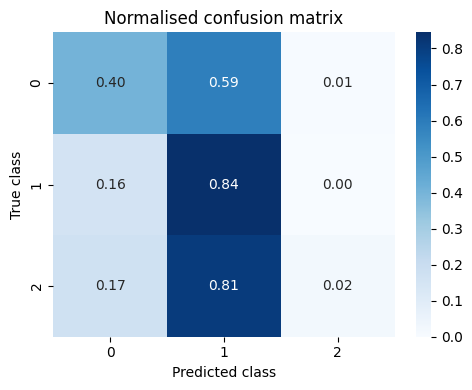

In [14]:
# ===============================
# Confusion-matrix heat-map (normalised row-wise)
# ===============================
print("----- Confusion Matrix (normalised) -----")
cm  = confusion_matrix(y_test, y_pred, labels=[0,1,2])
cmn = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(5,4))
sns.heatmap(cmn, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=["0","1","2"], yticklabels=["0","1","2"])
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("Normalised confusion matrix")
plt.tight_layout()
plt.show()

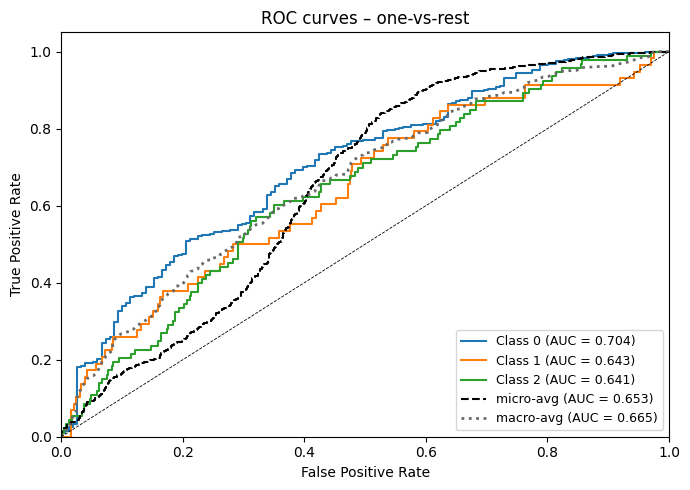

In [15]:
# ===============================
# ROC curves (one-vs-rest) + macro/micro averages
# ===============================
n_classes = 3
fpr = dict(); tpr = dict(); roc_auc = dict()

# one-vs-rest curves
for c in range(n_classes):
    fpr[c], tpr[c], _ = roc_curve((y_test == c).astype(int), y_proba[:, c])
    roc_auc[c] = auc(fpr[c], tpr[c])

# micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(
    pd.get_dummies(y_test).values.ravel(), y_proba.ravel()
)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# macro-average (average the FPR points first, then AU-C)
all_fpr = np.unique(np.concatenate([fpr[c] for c in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for c in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])
mean_tpr /= n_classes
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# plot
plt.figure(figsize=(7,5))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # default matplotlib palette

for c, col in zip(range(n_classes), colors):
    plt.plot(fpr[c], tpr[c], color=col, label=f"Class {c} (AUC = {roc_auc[c]:.3f})", lw=1.5)

# macro & micro
plt.plot(fpr["micro"], tpr["micro"], linestyle="--", color="black", label=f"micro-avg (AUC = {roc_auc['micro']:.3f})", lw=1.5)
plt.plot(fpr["macro"], tpr["macro"], linestyle=":", color="dimgray", label=f"macro-avg (AUC = {roc_auc['macro']:.3f})", lw=2)

plt.plot([0,1], [0,1], "k--", lw=0.6)
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC curves – one-vs-rest")
plt.legend(loc="lower right", fontsize=9)
plt.tight_layout()
plt.show()

In [16]:
# ===============================
# AUC scores table
# ===============================
print("\nArea-under-curve (AUC) scores:")
auc_tbl = pd.DataFrame(
    {f"Class {c}": roc_auc[c] for c in range(n_classes)} |
    {"micro-avg": roc_auc["micro"], "macro-avg": roc_auc["macro"]},
    index=["AUC"]
).T
auc_tbl.style.format("{:.4f}")


Area-under-curve (AUC) scores:


,AUC
Class 0,0.7043
Class 1,0.6433
Class 2,0.6410
micro-avg,0.6526
macro-avg,0.6647


In [17]:
# ===============================
# Features interpretation with SHAP
# ===============================
explainer = shap.Explainer(best_model.predict_proba, X_test)
shap_values = explainer(X_test)
print(shap_values)

PermutationExplainer explainer: 804it [00:36, 17.04it/s]                         


.values =
array([[[ 0.08661922, -0.0272144 , -0.05940481],
        [ 0.00256661,  0.00106693, -0.00363354],
        [ 0.01494365,  0.00102025, -0.01596391],
        ...,
        [ 0.04471905, -0.05590298,  0.01118393],
        [-0.01653476,  0.01130245,  0.00523231],
        [ 0.19944332, -0.18173996, -0.01770337]],

       [[-0.04782912,  0.01693876,  0.03089036],
        [-0.00223485,  0.01354318, -0.01130833],
        [ 0.05555654, -0.01868863, -0.0368679 ],
        ...,
        [ 0.03567235, -0.05600528,  0.02033293],
        [-0.02311479,  0.01033342,  0.01278137],
        [ 0.25613766, -0.21835736, -0.0377803 ]],

       [[-0.0211158 ,  0.01847988,  0.00263592],
        [ 0.00477667, -0.00027197, -0.00450469],
        [ 0.00919701,  0.00488881, -0.01408583],
        ...,
        [ 0.03856588, -0.05585343,  0.01728755],
        [-0.02429941,  0.01185502,  0.01244438],
        [ 0.25794088, -0.24121311, -0.01672777]],

       ...,

       [[ 0.0089478 , -0.03545995,  0.02651215],
 

/var/folders/8j/y46wyjvx641clg_t_cq0ggfc0000gn/T/ipykernel_17145/2161778229.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


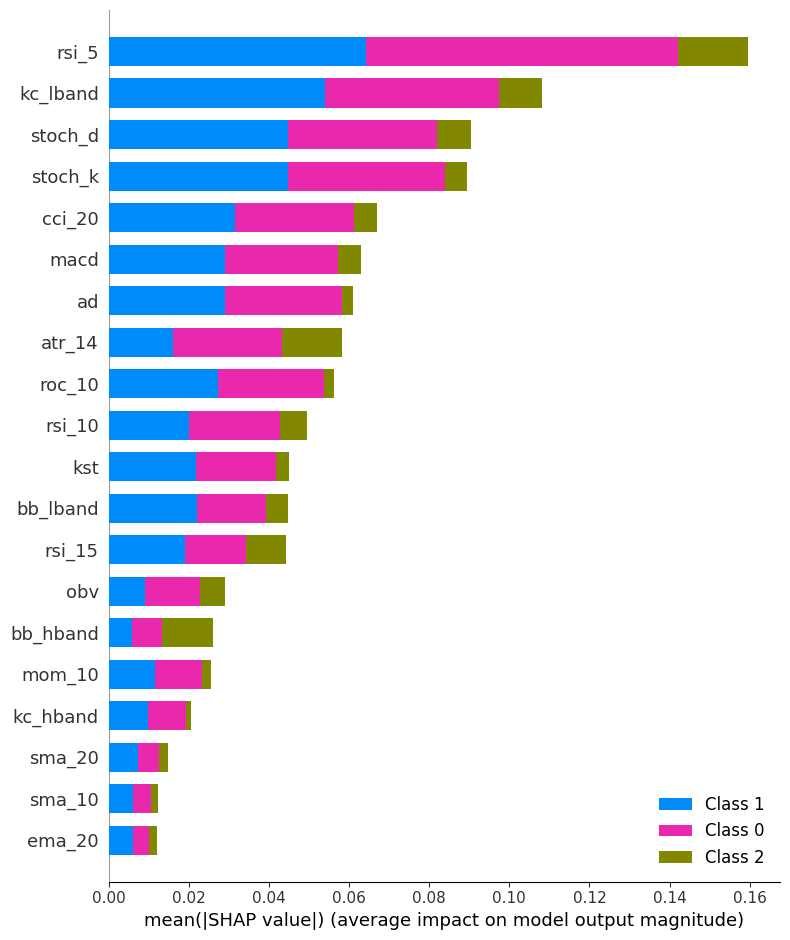

In [18]:
# ===============================
# Plot SHAP values
# ===============================
shap.summary_plot(shap_values, X_test)

/var/folders/8j/y46wyjvx641clg_t_cq0ggfc0000gn/T/ipykernel_17145/3593571791.py:77: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).




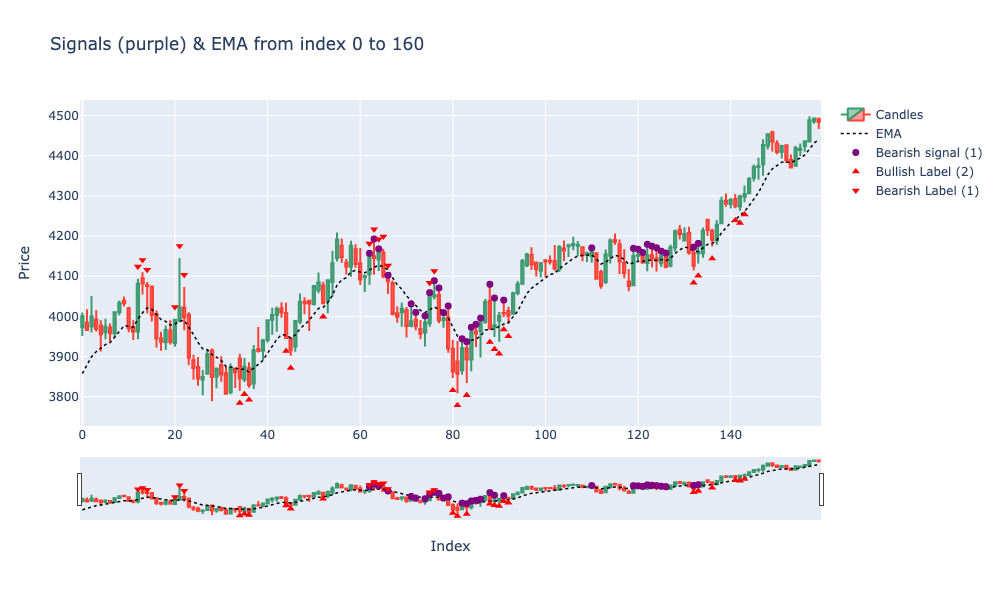

In [24]:
# ===============================
# Plot signals on OHLC candles with indicators for BUY/SELL strategy points
# ===============================
def plot_signals(test_df, pred_column='predictions', start=0, length=100):
    # Subset
    df_slice = test_df.iloc[start:start+length].copy()
    df_slice.reset_index(inplace=True)  # Reset for plotting

    # Candle plot
    fig = go.Figure(data=[go.Candlestick(
        x=df_slice['index'] if 'index' in df_slice else df_slice.index,
        open=df_slice['Open'],
        high=df_slice['High'],
        low=df_slice['Low'],
        close=df_slice['Close'],
        name='Candles'
    )])

    if 'ema_10' in df_slice.columns: # can be adjusted                    
        fig.add_trace(go.Scatter(
            x=df_slice['index'] if 'index' in df_slice else df_slice.index,
            y=df_slice['ema_10'],
            mode='lines',
            line=dict(width=1.5, dash='dot', color='black'),
            name='EMA'
        ))

    # Bullish signals
    bull_idx = df_slice[df_slice[pred_column] == 2].index
    fig.add_trace(go.Scatter(
        x=df_slice.loc[bull_idx, 'index'] if 'index' in df_slice else bull_idx,
        y=df_slice.loc[bull_idx, 'Low'] - (df_slice['High']-df_slice['Low']).mean()*0.1,
        mode='markers',
        marker=dict(size=7, color='purple', symbol='circle'),
        name='Bullish signal (2)'
    ))

    # Bearish signals
    bear_idx = df_slice[df_slice[pred_column] == 1].index
    fig.add_trace(go.Scatter(
        x=df_slice.loc[bear_idx, 'index'] if 'index' in df_slice else bear_idx,
        y=df_slice.loc[bear_idx, 'High'] + (df_slice['High']-df_slice['Low']).mean()*0.1,
        mode='markers',
        marker=dict(size=7, color='purple', symbol='circle'),
        name='Bearish signal (1)'
    ))

    # Bullish labels
    bull_idx = df_slice[df_slice[best_label] == 2].index
    fig.add_trace(go.Scatter(
        x=df_slice.loc[bull_idx, 'index'] if 'index' in df_slice else bull_idx,
        y=df_slice.loc[bull_idx, 'Low'] - (df_slice['High']-df_slice['Low']).mean()*0.5,
        mode='markers',
        marker=dict(size=7, color='red', symbol='triangle-up'),
        name='Bullish Label (2)'
    ))

    # Bearish labels
    bear_idx = df_slice[df_slice[best_label] == 1].index
    fig.add_trace(go.Scatter(
        x=df_slice.loc[bear_idx, 'index'] if 'index' in df_slice else bear_idx,
        y=df_slice.loc[bear_idx, 'High'] + (df_slice['High']-df_slice['Low']).mean()*0.5,
        mode='markers',
        marker=dict(size=7, color='red', symbol='triangle-down'),
        name='Bearish Label (1)'
    ))

    fig.update_layout(
        title=f"Signals (purple) & EMA from index {start} to {start+length}",
        xaxis_title="Index",
        yaxis_title="Price",
        showlegend=True,
        height=600,
        width=1000
    )
    png_path = "xgboost_last_test_sample.png"
    fig.write_image("xgboost_last_test_sample.png")
    fig.show()
    display(Image(filename=png_path)) # Display static image (GitHub-compatible)


plot_signals(test_df, pred_column="sel_preds", start=0, length=160)

/var/folders/8j/y46wyjvx641clg_t_cq0ggfc0000gn/T/ipykernel_17145/2286150132.py:38: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).




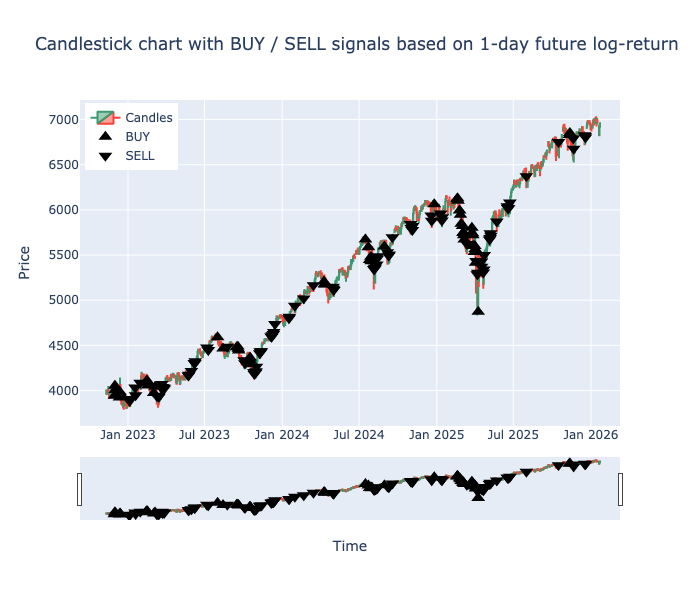

In [25]:
df_slice = df_ta.iloc[split_idx:].copy()
# Identify signals
buy_signals = df_slice[test_df[best_label] == 1]
sell_signals = df_slice[test_df[best_label] ==2]
# Create candlestick figure
fig = go.Figure(data=[go.Candlestick(
    x=df_slice.index,   # use index for x-axis
    open=df_slice['Open'],
    high=df_slice['High'],
    low=df_slice['Low'],
    close=df_slice['Close'],
    name='Candles'
)])
# BUY signals (triangle-up)
fig.add_trace(go.Scatter(
    x=buy_signals.index,
    y=buy_signals['Low'],  # anchor near candle low
    mode='markers', 
    marker=dict(symbol='triangle-up', size=12, color='black'), 
    name='BUY'
))
# SELL signals (triangle-down)
fig.add_trace(go.Scatter(
    x=sell_signals.index,
    y=sell_signals['High'],  # anchor near candle high
    mode='markers', 
    marker=dict(symbol='triangle-down', size=12, color='black'),
    name='SELL'
))
fig.update_layout(
    title=f"Candlestick chart with BUY / SELL signals based on 1-day future log-return",
    xaxis_title="Time", 
    yaxis_title="Price", 
    height=600,
    legend=dict(x=0.01, y=0.99)
)
path = "xgboost_full_test.png"
fig.write_image("xgboost_full_test.png")
fig.show()
display(Image(filename=path)) # Display static image (GitHub-compatible)